# Checkpoint 1

Importowanie bibliotek.

In [25]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from datetime import date
from collections import Counter

Wczytywanie danych.

In [26]:
gb_videos = pd.read_csv("data/GB_videos_5p.csv", sep=';')
gb_category = pd.read_json("data/GB_category_id.json")
us_videos = pd.read_csv("data/US_videos_5p.csv", sep=';')
us_category = pd.read_json("data/US_category_id.json")

Wstępne przetwarzanie danych

In [27]:
def change_date_format(df):
    data = df["trending_date"]
    data = data.split('.')
    data = list(map(int, data))
    if data[0] < 2000:
        data[0] += 2000
    return date(data[0], data[2], data[1])

gb_videos["trending_date"] = gb_videos.apply(lambda row: change_date_format(row), axis=1)
us_videos["trending_date"] = us_videos.apply(lambda row: change_date_format(row), axis=1)

## Wstępne statystyki

### Filmy z UK

<AxesSubplot:xlabel='trending_date'>

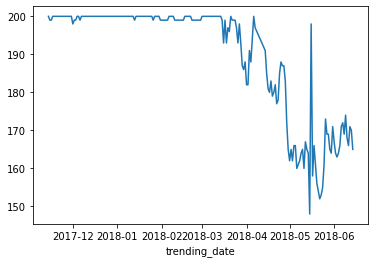

In [28]:
trending = gb_videos.groupby("trending_date")["trending_date"].count()
trending.plot()

<AxesSubplot:ylabel='Frequency'>

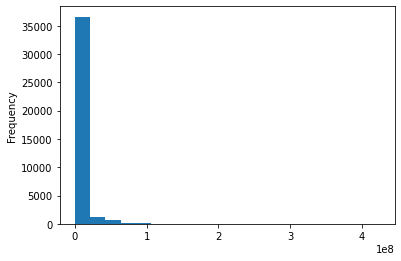

In [29]:
gb_videos["views"].plot.hist(bins=20)

(array([3.8788e+04, 7.1000e+01, 2.6000e+01, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 4.0000e+00, 1.3000e+01, 8.0000e+00]),
 array([      0. ,  194497.1,  388994.2,  583491.3,  777988.4,  972485.5,
        1166982.6, 1361479.7, 1555976.8, 1750473.9, 1944971. ]),
 <BarContainer object of 10 artists>)

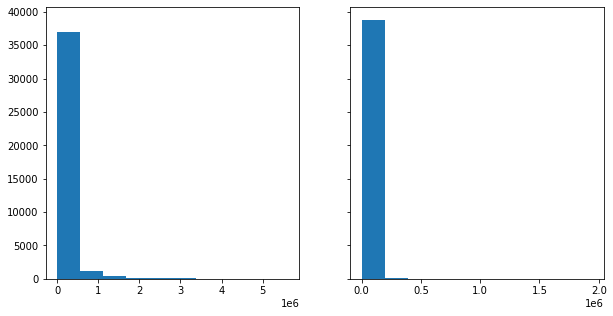

In [30]:
fig, ax = plt.subplots(1, 2, sharey="row", figsize=(10,5))

ax[0].hist(x=gb_videos["likes"], bins=10)
ax[1].hist(x=gb_videos["dislikes"], bins=10)

<AxesSubplot:ylabel='Frequency'>

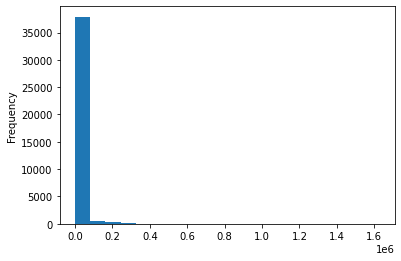

In [31]:
gb_videos["comment_count"].plot.hist(bins=20)

<AxesSubplot:>

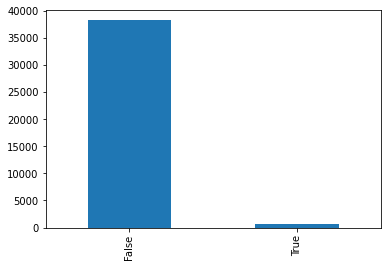

In [32]:
gb_videos["comments_disabled"].value_counts().plot.bar()

<AxesSubplot:>

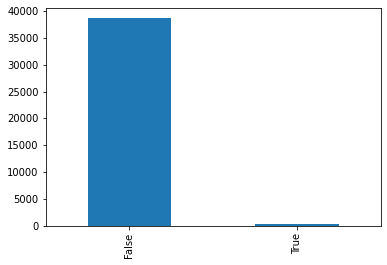

In [33]:
gb_videos["ratings_disabled"].value_counts().plot.bar()

<AxesSubplot:>

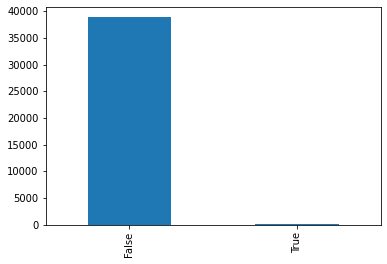

In [34]:
gb_videos["video_error_or_removed"].value_counts().plot.bar()

### Filmy z USA

<AxesSubplot:ylabel='Frequency'>

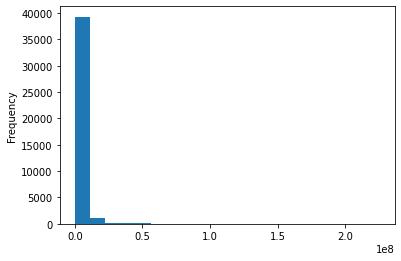

In [35]:
us_videos["views"].plot.hist(bins=20)

(array([4.0866e+04, 5.9000e+01, 1.0000e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00, 6.0000e+00]),
 array([      0.,  167442.,  334884.,  502326.,  669768.,  837210.,
        1004652., 1172094., 1339536., 1506978., 1674420.]),
 <BarContainer object of 10 artists>)

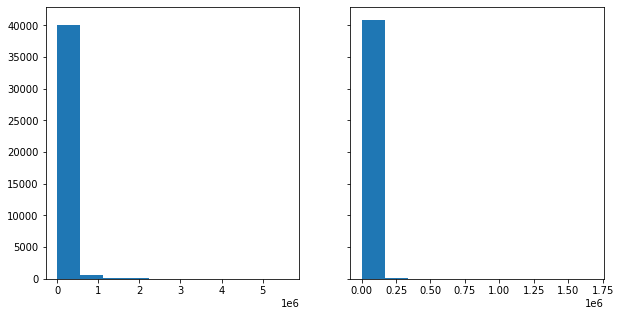

In [36]:
fig, ax = plt.subplots(1, 2, sharey="row", figsize=(10,5))

ax[0].hist(x=us_videos["likes"], bins=10)
ax[1].hist(x=us_videos["dislikes"], bins=10)

<AxesSubplot:ylabel='Frequency'>

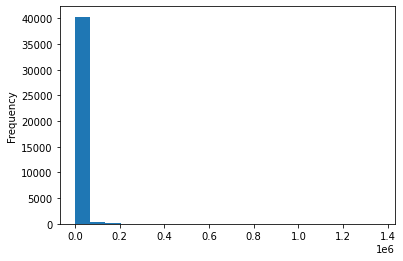

In [37]:
us_videos["comment_count"].plot.hist(bins=20)

<AxesSubplot:>

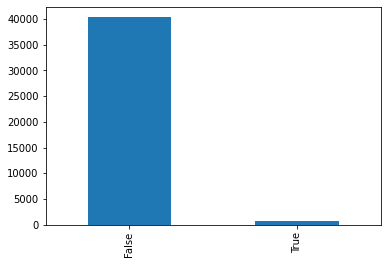

In [38]:
us_videos["comments_disabled"].value_counts().plot.bar()

<AxesSubplot:>

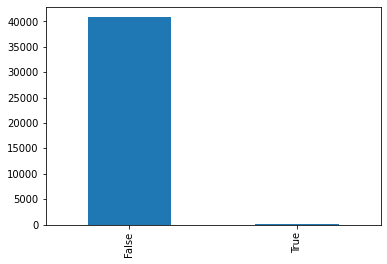

In [39]:
us_videos["ratings_disabled"].value_counts().plot.bar()

<AxesSubplot:>

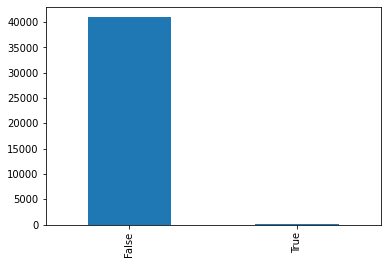

In [40]:
us_videos["video_error_or_removed"].value_counts().plot.bar()

## Zmiana reprezentacji danych

In [41]:
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
            "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've",
            "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of",
            "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "shan't", "she", "she'd",
            "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
            "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
            "they've", "this", "those", "through", "to", "until", "up", "very", "was", "wasn't", "we", "we'd",
            "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's",
            "which", "while", "who", "who's", "whom", "with", "would", "you", "you'd", "you'll", "you're", "you've",
            "your", "yours", "yourself", "yourselves", "above", "again", "against", "aren't", "below", "but", "can't",
            "cannot", "couldn't", "didn't", "doesn't", "don't", "down", "few", "hadn't", "hasn't", "haven't", "if",
            "isn't", "mustn't", "no", "nor", "not", "off", "out", "over", "shouldn't", "same", "too", "under", "why",
            "why's", "won't", "wouldn't"]

punctuation1 = "'*.,:;-_?!(){}[]<>"
punctuation2 = ["``", "''", "..."]

In [42]:
class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text 

class SimpleTokenizer():
    @staticmethod
    def tokenize(text):
        return text.split(" ")
    
class NltkTokenizer():
    @staticmethod
    def tokenize(text):
        return nltk.word_tokenize(text) 
    
class Tokenizer():
    @staticmethod
    def tokenize(text):
        text = BeforeTokenizationNormalizer.normalize(text)
        tokens = SimpleTokenizer.tokenize(text)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            match = None
            if (RE_HASHTAG.search(token)) or (RE_EMOTICONS.search(token)) or (RE_HTTP.search(token)):
                match = True
            if match is not None:
                pass
            else:
                del tokens[i]
                tokens[i:i] = NltkTokenizer.tokenize(token)
            i += 1
            
        porter = nltk.PorterStemmer()
        for i in range(len(tokens)):
            tokens[i] = porter.stem(tokens[i])
            
        tokens1 = []
        for ii in tokens:
            if (ii not in stopwords) and (ii not in punctuation1) and (ii not in punctuation2):
                tokens1.append(ii)
        return tokens1


In [43]:
gb_videos["description"] = gb_videos["description "].apply(lambda row: str(row))
gb_videos["description_tokens"] = gb_videos["description"].apply(lambda row: Tokenizer.tokenize(row))
gb_videos["title_tokens"] = gb_videos["title"].apply(lambda row: Tokenizer.tokenize(row))
gb_videos["tags_tokens"] = gb_videos["tags"].apply(lambda row: row.lower().replace('"', "").split("|"))

In [45]:
us_videos["description"] = us_videos["description "].apply(lambda row: str(row))
us_videos["description_tokens"] = us_videos["description"].apply(lambda row: Tokenizer.tokenize(row))
us_videos["title_tokens"] = us_videos["title"].apply(lambda row: Tokenizer.tokenize(row))
us_videos["tags_tokens"] = us_videos["tags"].apply(lambda row: row.lower().replace('"', "").split("|"))

In [46]:
wordsTitleGB = Counter()
wordsDescriptionGB = Counter()
wordsTagsGB = Counter()

for i in gb_videos["title_tokens"]:
    wordsTitleGB.update(i)

for i in gb_videos["description_tokens"]:
    wordsDescriptionGB.update(i)

for i in gb_videos["tags_tokens"]:
    wordsTagsGB.update(i)

In [47]:
wordsTitleUS = Counter()
wordsDescriptionUS = Counter()
wordsTagsUS = Counter()

for i in us_videos["title_tokens"]:
    wordsTitleUS.update(i)

for i in us_videos["description_tokens"]:
    wordsDescriptionUS.update(i)

for i in us_videos["tags_tokens"]:
    wordsTagsUS.update(i)

In [48]:
wordsTitleGB.most_common()

[('|', 8728),
 ('offici', 6983),
 ('video', 5928),
 ('&', 3173),
 ('trailer', 2755),
 ("'s", 2611),
 ('ft', 2518),
 ('music', 1883),
 ('2018', 1486),
 ('war', 1410),
 ('audio', 1288),
 ('star', 1230),
 ('feat', 1208),
 ('new', 1162),
 ('’', 1146),
 ('live', 1128),
 ('hd', 1072),
 ('last', 982),
 ('2017', 941),
 ('2', 905),
 ('vs', 773),
 ('love', 729),
 ('talk', 706),
 ('movi', 698),
 ('jedi', 679),
 ('(2018)', 679),
 ('lyric', 678),
 ('mv', 652),
 ('x', 641),
 ('s', 634),
 ("n't", 633),
 ('full', 624),
 ('b', 612),
 ('trump', 612),
 ('black', 602),
 ('j', 587),
 ('1', 568),
 ('day', 552),
 ('$', 544),
 ('remix', 535),
 ('christma', 534),
 ('like', 528),
 ('5', 526),
 ('time', 523),
 ('cardi', 520),
 ('perform', 514),
 ('teaser', 501),
 ('super', 495),
 ('world', 493),
 ('review', 492),
 ('make', 486),
 ('jame', 481),
 ('lil', 480),
 ('first', 479),
 ('thi', 474),
 ('season', 467),
 ('hi', 461),
 ('show', 459),
 ('year', 457),
 ('one', 457),
 ('get', 451),
 ('+', 448),
 ('smith', 435),

In [49]:
wordsDescriptionGB.most_common()

[('--', 39301),
 ('’', 36956),
 ('video', 25574),
 ("'s", 20445),
 ('music', 18460),
 ('thi', 17262),
 ('&', 16381),
 ('s', 13389),
 ('new', 11121),
 ('”', 10895),
 ('“', 10545),
 ('get', 10282),
 ('|', 10162),
 ('show', 9791),
 ('offici', 9263),
 ('now', 9044),
 ('us', 8913),
 ('channel', 8677),
 ('twitter', 8490),
 ('live', 8344),
 ('t', 8160),
 ('hi', 8075),
 ('–', 7974),
 ('facebook', 7502),
 ('youtub', 7473),
 ('can', 7442),
 ('instagram', 7346),
 ('one', 7283),
 ('like', 7122),
 ('star', 6851),
 ('\\n', 6740),
 ('subscrib', 6616),
 ('2018', 6585),
 ('watch', 6544),
 ('will', 6492),
 ('wa', 6391),
 ('make', 6193),
 ('just', 6074),
 ('love', 5931),
 ("n't", 5901),
 ('m', 5786),
 ('know', 5634),
 ('news', 5576),
 ('perform', 5569),
 ('late', 5538),
 ('use', 5309),
 ('avail', 5209),
 ('time', 4987),
 ('world', 4925),
 ('film', 4833),
 ('produc', 4804),
 ('na', 4786),
 ('want', 4765),
 ('go', 4754),
 ('play', 4684),
 ('night', 4640),
 ('album', 4454),
 ('jimmi', 4395),
 ('episod', 423

In [50]:
wordsTagsGB.most_common()

[('funny', 3010),
 ('comedy', 2920),
 ('music', 2810),
 ('pop', 2264),
 ('[none]', 2010),
 ('rap', 1750),
 ('trailer', 1724),
 ('music video', 1702),
 ('official', 1596),
 ('hip hop', 1510),
 ('2018', 1383),
 ('video', 1307),
 ('interview', 1261),
 ('live', 1167),
 ('records', 1137),
 ('humor', 1117),
 ('celebrity', 1102),
 ('star wars', 1102),
 ('vlog', 1090),
 ('movie', 1087),
 ('official video', 1052),
 ('film', 1022),
 ('television', 946),
 ('hollywood', 925),
 ('the', 918),
 ('late night', 872),
 ('new', 871),
 ('comedian', 846),
 ('entertainment', 835),
 ('talk show', 809),
 ('fashion', 805),
 ('christmas', 755),
 ('2017', 754),
 ('celebrities', 744),
 ('marvel', 740),
 ('news', 730),
 ('review', 717),
 ('atlantic records', 705),
 ('jokes', 688),
 ('beauty', 687),
 ('dance', 686),
 ('funny video', 682),
 ('r&b', 679),
 ('alternative', 655),
 ('new york', 648),
 ('clip', 637),
 ('famous', 629),
 ('the last jedi', 624),
 ('movies', 624),
 ('sports', 619),
 ('song', 615),
 ('nbc', 6

In [51]:
wordsTitleUS.most_common()

[('|', 10663),
 ('offici', 3989),
 ("'s", 3646),
 ('video', 2944),
 ('trailer', 2258),
 ('&', 2102),
 ('2018', 1852),
 ('’', 1304),
 ('ft', 1301),
 ('make', 1072),
 ('vs', 1046),
 ('new', 998),
 ('live', 983),
 ('music', 923),
 ('thi', 920),
 ('2017', 884),
 ('makeup', 876),
 ('s', 853),
 ('2', 850),
 ('audio', 839),
 ('day', 815),
 ('hd', 796),
 ("n't", 768),
 ('first', 742),
 ('get', 738),
 ('game', 735),
 ('whi', 705),
 ('tri', 697),
 ('star', 672),
 ('challeng', 664),
 ('show', 654),
 ('war', 641),
 ('$', 627),
 ('love', 615),
 ('lyric', 607),
 ('movi', 607),
 ('full', 605),
 ('time', 580),
 ('world', 580),
 ('black', 573),
 ('10', 557),
 ('test', 547),
 ('one', 519),
 ('5', 511),
 ('season', 511),
 ('hi', 508),
 ('review', 499),
 ('talk', 482),
 ('react', 480),
 ('1', 463),
 ('teaser', 461),
 ('best', 460),
 ('like', 445),
 ('christma', 435),
 ('year', 428),
 ('look', 425),
 ('will', 417),
 ('super', 415),
 ('life', 415),
 ('watch', 413),
 ('jame', 410),
 ('cat', 405),
 ('face', 4

In [52]:
wordsDescriptionUS.most_common()

[('--', 102762),
 ('video', 35654),
 ('’', 33972),
 ('thi', 28875),
 ("'s", 27959),
 ('follow', 23259),
 ('subscrib', 21096),
 ('twitter', 21073),
 ('music', 19110),
 ('instagram', 19082),
 ('facebook', 18738),
 ('get', 17737),
 ('s', 17259),
 ('watch', 17006),
 ('us', 15791),
 ('new', 15221),
 ('like', 15140),
 ('&', 15122),
 ('|', 14108),
 ('»', 13467),
 ('channel', 12743),
 ('”', 12281),
 ('“', 11750),
 ('use', 11563),
 ('show', 11349),
 ('youtub', 11132),
 ('►', 10872),
 ('make', 10818),
 ('can', 9683),
 ('product', 9678),
 ('hi', 8965),
 ('t', 8702),
 ('wa', 8662),
 ('now', 8624),
 ('one', 8389),
 ('love', 8380),
 ('news', 8165),
 ('live', 8129),
 ('check', 7836),
 ('thank', 7531),
 ('time', 7517),
 ('world', 7370),
 ('offici', 7343),
 ('produc', 7321),
 ('see', 7213),
 ('will', 6961),
 ("n't", 6950),
 ('go', 6845),
 ('websit', 6772),
 ('just', 6539),
 ('find', 6532),
 ('link', 6505),
 ('want', 6457),
 ('know', 6425),
 ('episod', 6220),
 ('star', 6123),
 ('film', 6055),
 ('first',

In [53]:
wordsTagsUS.most_common()

[('funny', 4142),
 ('comedy', 3647),
 ('how to', 1702),
 ('music', 1664),
 ('pop', 1634),
 ('[none]', 1535),
 ('trailer', 1413),
 ('food', 1280),
 ('2018', 1275),
 ('news', 1254),
 ('review', 1239),
 ('makeup', 1238),
 ('science', 1237),
 ('humor', 1210),
 ('celebrity', 1130),
 ('diy', 1110),
 ('tutorial', 1054),
 ('video', 1031),
 ('television', 1024),
 ('live', 1020),
 ('interview', 988),
 ('vlog', 958),
 ('entertainment', 951),
 ('animation', 947),
 ('beauty', 923),
 ('movie', 908),
 ('official', 896),
 ('comedian', 879),
 ('cooking', 864),
 ('fun', 849),
 ('hollywood', 847),
 ('cute', 829),
 ('buzzfeed', 804),
 ('celebrities', 788),
 ('talk show', 788),
 ('late night', 783),
 ('recipe', 778),
 ('nbc', 760),
 ('family friendly', 754),
 ('sports', 752),
 ('animals', 723),
 ('best', 718),
 ('music video', 712),
 ('education', 711),
 ('fashion', 696),
 ('movies', 696),
 ('challenge', 688),
 ('records', 685),
 ('2017', 676),
 ('funny video', 675),
 ('basketball', 655),
 ('nba', 634),
 (

In [54]:
AT_GB = gb_videos[["views", "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "video_error_or_removed"]]

AT_GB["title_length"] = gb_videos["title"].apply(lambda row: len(row))
AT_GB["title_uppercase"] = gb_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_GB["title_emoticons"] = gb_videos["title"].apply(lambda row: RE_EMOTICONS.search(str(row))!=None)
AT_GB["title_hashtag"] = gb_videos["title"].apply(lambda row: RE_HASHTAG.search(str(row))!=None)
AT_GB["title_interpunction"] = gb_videos["title"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_GB["description_length"] = gb_videos["description"].apply(lambda row: len(str(row)))
AT_GB["description_uppercase"] = gb_videos["description"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_GB["description_link"] = gb_videos["description"].apply(lambda row: RE_HTTP.search(row)!=None)
AT_GB["description_emoticons"] = gb_videos["description"].apply(lambda row: RE_EMOTICONS.search(row)!=None)
AT_GB["description_hashtag"] = gb_videos["description"].apply(lambda row: RE_HASHTAG.search(row)!=None)
AT_GB["description_interpunction"] = gb_videos["description"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_GB["tag_number"] = gb_videos["tags"].apply(lambda row: len(row.split("|")))

display(AT_GB)

<ipython-input-54-a224da13f407>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_GB["title_length"] = gb_videos["title"].apply(lambda row: len(row))
<ipython-input-54-a224da13f407>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_GB["title_uppercase"] = gb_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
<ipython-input-54-a224da13f407>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length,title_uppercase,title_emoticons,title_hashtag,title_interpunction,description_length,description_uppercase,description_link,description_emoticons,description_hashtag,description_interpunction,tag_number
0,7224515,55681,10247,9479,False,False,False,45,0.155556,False,False,1,821,0.047503,True,True,False,25,9
1,1053632,25561,2294,2757,False,False,False,41,0.195122,False,False,5,417,0.095923,True,True,False,35,36
2,17158579,787420,43420,125882,False,False,False,42,0.142857,False,False,4,594,0.048822,True,True,False,39,6
3,27833,193,12,37,False,False,False,76,0.105263,False,False,1,396,0.070707,True,True,False,21,9
4,9815,30,2,30,False,False,False,55,0.036364,False,False,1,151,0.039735,False,False,False,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38911,25066952,268088,12783,9933,False,False,False,61,0.262295,False,False,4,890,0.131461,True,True,False,62,4
38912,1492219,61998,13781,24330,False,False,False,51,0.156863,False,False,3,475,0.204211,True,True,False,28,41
38913,29641412,394830,8892,19988,False,False,False,34,0.117647,False,False,4,321,0.074766,True,True,False,22,17
38914,14317515,151870,45875,26766,False,False,False,75,0.160000,False,False,6,195,0.061538,True,True,False,6,8


In [55]:
AT_US = us_videos[["views", "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "video_error_or_removed"]]

AT_US["title_length"] = us_videos["title"].apply(lambda row: len(row))
AT_US["title_uppercase"] = us_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_US["title_emoticons"] = us_videos["title"].apply(lambda row: RE_EMOTICONS.search(str(row))!=None)
AT_US["title_hashtag"] = us_videos["title"].apply(lambda row: RE_HASHTAG.search(str(row))!=None)
AT_US["title_interpunction"] = us_videos["title"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_US["description_length"] = us_videos["description"].apply(lambda row: len(str(row)))
AT_US["description_uppercase"] = us_videos["description"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_US["description_link"] = us_videos["description"].apply(lambda row: RE_HTTP.search(row)!=None)
AT_US["description_emoticons"] = us_videos["description"].apply(lambda row: RE_EMOTICONS.search(row)!=None)
AT_US["description_hashtag"] = us_videos["description"].apply(lambda row: RE_HASHTAG.search(row)!=None)
AT_US["description_interpunction"] = us_videos["description"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_US["tag_number"] = us_videos["tags"].apply(lambda row: len(row.split("|")))

display(AT_US)

<ipython-input-55-42a2e6040f72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_US["title_length"] = us_videos["title"].apply(lambda row: len(row))
<ipython-input-55-42a2e6040f72>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_US["title_uppercase"] = us_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
<ipython-input-55-42a2e6040f72>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length,title_uppercase,title_emoticons,title_hashtag,title_interpunction,description_length,description_uppercase,description_link,description_emoticons,description_hashtag,description_interpunction,tag_number
0,748374,57527,2966,15954,False,False,False,34,0.823529,False,False,0,1379,0.179840,True,True,False,85,1
1,2418783,97185,6146,12703,False,False,False,62,0.177419,False,False,3,615,0.055285,True,True,False,20,4
2,3191434,146033,5339,8181,False,False,False,53,0.150943,False,False,1,1133,0.120918,True,True,False,107,23
3,343168,10172,666,2146,False,False,False,32,0.125000,False,False,2,1370,0.067883,True,True,True,73,27
4,2095731,132235,1989,17518,False,False,False,24,0.500000,False,False,3,602,0.039867,True,True,False,35,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,1685609,38160,1385,2657,False,False,False,28,0.178571,False,False,0,46,0.152174,False,False,False,2,14
40945,1064798,60008,382,3936,False,False,False,26,0.153846,False,False,1,3,0.000000,False,False,False,0,1
40946,1066451,48068,1032,3992,False,False,False,84,0.702381,False,False,2,775,0.362581,True,True,False,43,24
40947,5660813,192957,2846,13088,False,False,False,35,0.171429,False,False,0,3268,0.173501,True,True,True,236,22
